In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import torch

# ============================================
# GIẢI PHÁP CHO VẤN ĐỀ OVERFIT & METRICS THẤP
# ============================================

print("🔍 Checking GPU...")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================
# CONFIG TỐI ƯU - FIX OVERFIT
# ============================================

model = YOLO("yolov8m.pt")

results = model.train(
    # ===== DATA =====
    data="/content/drive/MyDrive/food_detection/Food Data.v3i.yolov8/data.yaml",

    # ===== TRAINING CONFIG =====
    epochs=100,         # Tăng epochs để model học tốt hơn
    imgsz=640,          # Giữ nguyên
    batch=16,           # Giữ nguyên (T4 GPU phù hợp)

    # ===== OPTIMIZER - ĐIỀU CHỈNH ĐỂ GIẢM OVERFIT =====
    optimizer="AdamW",
    lr0=0.0005,         # ❗ GIẢM learning rate: 0.001 → 0.0005
    lrf=0.01,           # Final LR = lr0 * lrf
    momentum=0.937,
    weight_decay=0.001, # ❗ TĂNG weight decay: 0.0005 → 0.001 (regularization)
    warmup_epochs=5.0,  # ❗ Tăng warmup để training ổn định hơn
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # ===== AUGMENTATION - GIẢM MẠNH ĐỂ TRÁNH NHIỄU =====
    # Color augmentation - GIỮ NGUYÊN
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,

    # Geometric augmentation - GIẢM MẠNH
    degrees=3.0,        # ❗ 5.0 → 3.0
    translate=0.1,      # Giữ nguyên
    scale=0.2,          # ❗ 0.5 → 0.2 (GIẢM MẠNH)
    shear=0.0,          # ❗ 2.0 → 0.0 (TẮT HOÀN TOÀN - food không bị shear)
    perspective=0.0,    # ❗ 0.0005 → 0.0 (TẮT)

    # Flip
    flipud=0.0,         # Giữ nguyên (food không lộn ngược)
    fliplr=0.5,         # Giữ nguyên

    # Advanced augmentation - GIẢM MẠNH
    mosaic=0.5,         # ❗ 1.0 → 0.5 (giảm mosaic)
    mixup=0.0,          # ❗ 0.2 → 0.0 (TẮT mixup - làm mất chi tiết food)
    copy_paste=0.0,

    # ===== REGULARIZATION - THÊM ĐỂ CHỐNG OVERFIT =====
    dropout=0.1,        # ❗ THÊM dropout
    label_smoothing=0.1,# ❗ THÊM label smoothing

    # ===== LOSS WEIGHTS =====
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # ===== DATA LOADING =====
    cache="ram",        # ❗ Cache vào RAM để training nhanh hơn
    device='cpu',       # Changed from 0 to 'cpu'
    workers=4,          # ❗ Giảm workers để tránh memory issues

    # ===== VALIDATION & EARLY STOPPING =====
    patience=50,        # ❗ TĂNG patience: 30 → 50 (cho phép model học lâu hơn)
    save=True,
    save_period=10,     # Save checkpoint mỗi 10 epochs
    val=True,
    plots=True,

    # ===== OUTPUT =====
    project="food_detection",
    name="yolov8m_antioverfit_v2",
    exist_ok=True,
    verbose=True,

    # ===== ADVANCED =====
    amp=True,           # Mixed precision training
    fraction=1.0,       # Use 100% of dataset
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)
print("\n📊 Validation Metrics:")
print(f"mAP50: {results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {results.results_dict['metrics/recall(B)']:.4f}")

print("\n📁 Model saved at:")
print(f"   Best: food_detection/yolov8m_antioverfit_v2/weights/best.pt")
print(f"   Last: food_detection/yolov8m_antioverfit_v2/weights/last.pt")

# ============================================
# EVALUATE MODEL
# ============================================
print("\n🔍 Running detailed validation...")
best_model = YOLO("food_detection/yolov8m_antioverfit_v2/weights/best.pt")
metrics = best_model.val()

print("\n📈 Per-class metrics:")
print(metrics.results_dict)

# ============================================
# TEST INFERENCE
# ============================================
print("\n🎯 Testing inference...")
# Uncomment khi có test image
# results = best_model.predict(
#     source="path/to/test/image.jpg",
#     conf=0.25,
#     save=True,
#     project="food_detection",
#     name="predictions"
# )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/food_detection/Food Data.v3i.yolov8/data.yaml, degrees=3.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, e

In [ ]:
from ultralytics import YOLO
import torch

# ============================
# CHECK GPU
# ============================
print("🔍 Checking GPU...")
assert torch.cuda.is_available(), "❌ CHƯA BẬT GPU"
print("✅ GPU:", torch.cuda.get_device_name(0))

# ============================
# LOAD MODEL (VIP CHOICE)
# ============================
model = YOLO("yolov8s.pt")   # ✅ BEST cho dataset này

# ============================
# TRAIN CONFIG – VIP STABLE
# ============================
results = model.train(
    # ===== DATA =====
    data="/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/data.yaml",

    # ===== BASIC =====
    epochs=100,          # học đủ lâu
    imgsz=640,
    batch=8,             # ổn định gradient

    # ===== OPTIMIZER =====
    optimizer="AdamW",
    lr0=0.0003,          # 🔥 then chốt: LR THẤP
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3.0,

    # ===== AUGMENTATION (FOOD-OPTIMIZED) =====
    hsv_h=0.015,
    hsv_s=0.5,
    hsv_v=0.3,

    degrees=3.0,
    translate=0.1,
    scale=0.25,
    shear=0.0,
    perspective=0.0,

    fliplr=0.5,
    flipud=0.0,

    mosaic=0.3,          # ❗ GIẢM MẠNH
    mixup=0.0,
    copy_paste=0.0,

    # ===== LOSS =====
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # ===== SYSTEM =====
    device=0,            # 🔥 GPU
    workers=2,
    cache=False,         # ❗ KHÔNG CACHE
    amp=True,

    # ===== EARLY STOP =====
    patience=25,

    # ===== OUTPUT =====
    project="food_detection",
    name="yolov8s_vietfood_VIP",
    exist_ok=True,
    plots=True,
    verbose=True
)

print("✅ TRAIN DONE")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
✅ GPU: Tesla T4
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/data.yaml, degrees=3.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.

In [ ]:
import os
from collections import defaultdict
import yaml

# ================== CONFIG ==================
DATASET_PATH = "/content/drive/MyDrive/food_detection/Food Data.v3i.yolov8"
# ============================================

splits = ["train", "valid", "test"]

class_images = {s: defaultdict(set) for s in splits}
class_instances = {s: defaultdict(int) for s in splits}

def scan_split(split):
    label_dir = os.path.join(DATASET_PATH, split, "labels")

    if not os.path.isdir(label_dir):
        print(f"⚠️ Skip {split}: labels folder not found")
        return

    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue

        img_name = file.replace(".txt", "")
        label_path = os.path.join(label_dir, file)

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            cls = int(line.split()[0])
            class_instances[split][cls] += 1
            class_images[split][cls].add(img_name)

# Scan all splits
for s in splits:
    scan_split(s)

# Load class names
with open(os.path.join(DATASET_PATH, "data.yaml"), "r") as f:
    names = yaml.safe_load(f)["names"]

# ================== REPORT ==================
print("="*70)
print("📊 DATASET STATISTICS")
print("="*70)

for cls_id, cls_name in enumerate(names):
    print(f"\n🔹 Class {cls_id}: {cls_name}")
    for s in splits:
        imgs = len(class_images[s][cls_id])
        inst = class_instances[s][cls_id]
        print(f"   {s:5}: {imgs:4} images | {inst:4} instances")

print("\n" + "="*70)
print("⚠️ CLASSES WITH LOW DATA (RECOMMENDED TO DROP)")
print("="*70)

for cls_id, cls_name in enumerate(names):
    total_imgs = sum(len(class_images[s][cls_id]) for s in splits)
    if total_imgs < 50:
        print(f"❌ {cls_name}: {total_imgs} images")


📊 DATASET STATISTICS

🔹 Class 0: Banh-beo
   train:  153 images |  645 instances
   valid:   48 images |  238 instances
   test :   33 images |  133 instances

🔹 Class 1: Banh-bot-loc
   train:  157 images |  230 instances
   valid:   36 images |   58 instances
   test :   21 images |   30 instances

🔹 Class 2: Banh-can
   train:  137 images |  263 instances
   valid:   38 images |   69 instances
   test :   19 images |   39 instances

🔹 Class 3: Banh-canh
   train:  195 images |  214 instances
   valid:   65 images |   72 instances
   test :   27 images |   28 instances

🔹 Class 4: Banh-chung
   train:  120 images |  191 instances
   valid:   31 images |   61 instances
   test :   16 images |   28 instances

🔹 Class 5: Banh-cuon
   train:  268 images |  301 instances
   valid:   68 images |   78 instances
   test :   30 images |   35 instances

🔹 Class 6: Banh-duc
   train:  105 images |  126 instances
   valid:   20 images |   26 instances
   test :   12 images |   12 instances

🔹 Cl

In [ ]:
from ultralytics import YOLO

# Load best model
model = YOLO("food_detection/yolov8s_vietfood_VIP/weights/best.pt")

# Validate
metrics = model.val(
    data="/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/data.yaml",
    imgsz=640,
    device=0
)

# Print metrics
print("====== 📊 BEST MODEL METRICS ======")
print(f"mAP50     : {metrics.box.map50:.4f}")
print(f"mAP50-95  : {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall   : {metrics.box.mr:.4f}")


Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,194 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 24.6±8.5 MB/s, size: 54.7 KB)
val: Scanning /content/drive/MyDrive/food_model/Food Data.v3i.yolov8/valid/labels.cache... 1641 images, 25 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1641/1641 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 103/103 2.5it/s 40.9s
                   all       1641       2311       0.72      0.649      0.711      0.514
              Banh-beo         48        238      0.868      0.777      0.886      0.598
          Banh-bot-loc         36         58      0.557      0.397      0.478      0.335
              Banh-can         38         69      0.565      0.623      0.574      0.406
             Banh-canh         65         72      0.664      0.556       0.62      0.461
       

In [ ]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import yaml

# ================================
# PATHS
# ================================
MODEL_PATH = "food_detection/yolov8s_vietfood_VIP/weights/best.pt"
IMG_DIR = "/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/test/images"
LABEL_DIR = "/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/test/labels"
DATA_YAML = "/content/drive/MyDrive/food_model/Food Data.v3i.yolov8/data.yaml"

# ================================
# LOAD CLASS NAMES
# ================================
with open(DATA_YAML, "r") as f:
    data = yaml.safe_load(f)
names = data["names"]

# ================================
# LOAD MODEL
# ================================
model = YOLO(MODEL_PATH)

# ================================
# LOAD 20 IMAGES
# ================================
images = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
])[:20]

assert len(images) == 20, "❌ Không đủ 20 ảnh test"

image_paths = [os.path.join(IMG_DIR, f) for f in images]

# ================================
# PREDICT
# ================================
results = model.predict(
    source=image_paths,
    imgsz=640,
    conf=0.35,
    iou=0.6,
    save=False,
    verbose=False
)

# ================================
# HELPER: READ TRUE LABEL
# ================================
def get_true_classes(label_path):
    if not os.path.exists(label_path):
        return ["None"]
    classes = set()
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls_id = int(line.split()[0])
            classes.add(names[cls_id])
    return list(classes)

# ================================
# PLOT GRID 4x5
# ================================
fig, axes = plt.subplots(4, 5, figsize=(22, 16))
axes = axes.flatten()

for i, (img_name, r) in enumerate(zip(images, results)):
    img_path = os.path.join(IMG_DIR, img_name)
    label_path = os.path.join(LABEL_DIR, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Ground truth
    true_classes = get_true_classes(label_path)
    true_text = ", ".join(true_classes)

    # Prediction
    if len(r.boxes) > 0:
        cls_id = int(r.boxes.cls[0])
        conf = float(r.boxes.conf[0])
        pred_text = f"{names[cls_id]} ({conf:.2f})"
    else:
        pred_text = "None"

    # Annotated image
    annotated = r.plot(conf=True)

    axes[i].imshow(annotated)
    axes[i].axis("off")
    axes[i].set_title(
        f"GT: {true_text}\nPred: {pred_text}",
        fontsize=11
    )

plt.tight_layout()
plt.show()


In [ ]:
import torch

print("🔍 Checking GPU...")
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")
else:
    print("❌ NO GPU — STOP HERE")


🔍 Checking GPU...
CUDA available: True
GPU: Tesla T4
VRAM: 15.828320256 GB


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")


In [ ]:
import shutil
import os

# Source (nơi model được train)
source = "food_detection/yolov8s_vietfood_VIP"

# Destination (Google Drive)
destination = "/content/drive/MyDrive/food_model/yolov8s_vietfood_VIP"

print("📋 Copying model to Google Drive...")

# Copy
if os.path.exists(source):
    shutil.copytree(source, destination, dirs_exist_ok=True)
    print(f"✅ Copied to: {destination}")
    print("👉 Go to Google Drive to download!")

    # Show size
    total_size = sum(
        os.path.getsize(os.path.join(dirpath, filename))
        for dirpath, dirnames, filenames in os.walk(destination)
        for filename in filenames
    )
    print(f"📊 Total size: {total_size / (1024**2):.2f} MB")
else:
    print(f"❌ Source not found: {source}")
    print("\n🔍 Searching for model...")

    # Search
    for root, dirs, files in os.walk("/content"):
        if "best.pt" in files:
            print(f"✅ Found model at: {root}")

📋 Copying model to Google Drive...
✅ Copied to: /content/drive/MyDrive/food_model/yolov8s_vietfood_VIP
👉 Go to Google Drive to download!
📊 Total size: 51.67 MB


In [3]:
from pathlib import Path
import zipfile
from tqdm import tqdm

# =========================
# PATHS
# =========================
zip_path = Path("/content/drive/MyDrive/food_model/dataset_filtered2.zip")
extract_to = Path("/content/dataset_filtered")

# =========================
# Tạo folder nếu chưa có
# =========================
extract_to.mkdir(parents=True, exist_ok=True)

# =========================
# Giải nén với tiến trình
# =========================
print("📂 Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    files = zip_ref.namelist()
    for f in tqdm(files, desc="Extracting files", unit="file"):
        zip_ref.extract(f, extract_to)

print(f"✅ Dataset đã giải nén xong tại: {extract_to}")


📂 Extracting dataset...


Extracting files: 100%|██████████| 48086/48086 [01:17<00:00, 620.64file/s]  

✅ Dataset đã giải nén xong tại: /content/dataset_filtered


In [ ]:
from ultralytics import YOLO
import torch

# ============================
# CHECK GPU
# ============================
print("🔍 Checking GPU...")
assert torch.cuda.is_available(), "❌ CHƯA BẬT GPU"
print("✅ GPU:", torch.cuda.get_device_name(0))

# ============================
# LOAD MODEL
# ============================
model = YOLO("yolov8s.pt")

# ============================
# TRAIN CONFIG – OPTIMIZED
# ============================
results = model.train(
    # ===== DATA =====
    data="/content/dataset_filtered/dataset_filtered/food_refined.yaml",

    # ===== BASIC =====
    epochs=40,
    imgsz=640,
    batch=8,

    # ===== OPTIMIZER =====
    optimizer="AdamW",
    lr0=0.0003,
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3.0,

    # ===== AUGMENTATION (FOOD-OPTIMIZED) =====
    hsv_h=0.015,
    hsv_s=0.3,      # 🔧 Giảm từ 0.5
    hsv_v=0.2,      # 🔧 Giảm từ 0.3

    degrees=3.0,
    translate=0.1,
    scale=0.25,
    shear=0.0,
    perspective=0.0,

    fliplr=0.5,
    flipud=0.0,

    mosaic=0.3,
    mixup=0.0,
    copy_paste=0.0,

    # ===== LOSS =====
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # ===== SYSTEM =====
    device=0,
    workers=4,          # 🔧 Tăng từ 2
    cache=False,        # 🔧 BẬT CACHE
    amp=True,

    # ===== VALIDATION =====
    val=True,           # 🔧 THÊM
    save_period=10,     # 🔧 THÊM

    # ===== EARLY STOP =====
    patience=25,

    # ===== OUTPUT =====
    project="/content/drive/MyDrive/food_model/food_detection_49class",
    name="yolov8s_vietfood_49class",
    exist_ok=True,
    plots=True,
    verbose=True
)

print("✅ TRAIN DONE")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
✅ GPU: Tesla T4
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_filtered/dataset_filtered/food_refined.yaml, degrees=3.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_

In [ ]:
from ultralytics import YOLO
import torch

# ============================
# CHECK GPU
# ============================
print("🔍 Checking GPU...")
assert torch.cuda.is_available(), "❌ CHƯA BẬT GPU"
print("✅ GPU:", torch.cuda.get_device_name(0))

# ============================
# LOAD MODEL
# ============================
model = YOLO("yolov8s.pt")

# ============================
# TRAIN CONFIG – OPTIMIZED
# ============================
results = model.train(
    # ===== DATA =====
    data="/content/dataset_filtered/dataset_filtered2/food_refined.yaml",

    # ===== BASIC =====
    epochs=40,
    imgsz=640,
    batch=8,

    # ===== OPTIMIZER =====
    optimizer="AdamW",
    lr0=0.0003,
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3.0,

    # ===== AUGMENTATION (FOOD-OPTIMIZED) =====
    hsv_h=0.015,
    hsv_s=0.3,      # 🔧 Giảm từ 0.5
    hsv_v=0.2,      # 🔧 Giảm từ 0.3

    degrees=3.0,
    translate=0.1,
    scale=0.25,
    shear=0.0,
    perspective=0.0,

    fliplr=0.5,
    flipud=0.0,

    mosaic=0.3,
    mixup=0.0,
    copy_paste=0.0,

    # ===== LOSS =====
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # ===== SYSTEM =====
    device=0,
    workers=4,          # 🔧 Tăng từ 2
    cache=False,        # 🔧 BẬT CACHE
    amp=True,

    # ===== VALIDATION =====
    val=True,           # 🔧 THÊM
    save_period=10,     # 🔧 THÊM

    # ===== EARLY STOP =====
    patience=25,

    # ===== OUTPUT =====
    project="/content/drive/MyDrive/food_model/food_detection_36class_1100",
    name="yolov8s_vietfood_36class_1100",
    exist_ok=True,
    plots=True,
    verbose=True
)

print("✅ TRAIN DONE")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
✅ GPU: Tesla T4
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_filtered/dataset_filtered2/food_refined.yaml, degrees=3.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv

In [5]:
from ultralytics import YOLO
import torch
from pathlib import Path

# ============================
# CHECK GPU
# ============================
print("🔍 Checking GPU...")
assert torch.cuda.is_available(), "❌ CHƯA BẬT GPU"
print("✅ GPU:", torch.cuda.get_device_name(0))

# ============================
# LOAD CHECKPOINT CŨ
# ============================
LAST_PT = (
    "/content/drive/MyDrive/food_model/food_detection_36class_1100-20260126T072119Z-3-001/food_detection_36class_1100/yolov8s_vietfood_36class_1100/weights/last.pt"
)

assert Path(LAST_PT).exists(), "❌ Không thấy last.pt"
print("✅ Found checkpoint:", LAST_PT)

model = YOLO(LAST_PT)

# ============================
# TRAIN → TẠO FOLDER MỚI
# ============================
results = model.train(
    data="/content/dataset_filtered/dataset_filtered2/food_refined.yaml",

    epochs=40,
    imgsz=640,
    batch=8,

    optimizer="AdamW",
    lr0=0.0003,
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3.0,

    hsv_h=0.015,
    hsv_s=0.3,
    hsv_v=0.2,

    degrees=3.0,
    translate=0.1,
    scale=0.25,

    fliplr=0.5,
    mosaic=0.3,

    box=7.5,
    cls=0.5,
    dfl=1.5,

    device=0,
    workers=4,
    amp=True,

    val=True,
    patience=25,

    # 🔥 FOLDER MỚI NẰM Ở ĐÂY
    project="/content/drive/MyDrive/food_model/food_detection_36class_1100-20260126T072119Z-3-001",
    name="yolov8s_vietfood_36class_1100_resume",
    exist_ok=True,

    resume=True,   # resume từ last.pt
    plots=True,
    verbose=True,
)

print("✅ TRAIN DONE")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
✅ GPU: Tesla T4
✅ Found checkpoint: /content/drive/MyDrive/food_model/food_detection_36class_1100-20260126T072119Z-3-001/food_detection_36class_1100/yolov8s_vietfood_36class_1100/weights/last.pt
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_filtered/dataset_filtered2/food_refined.yaml, degrees=3.0, deterministic=True, device=0, dfl=1.

📌 Đang load model BEST.PT...

🚀 Đang đánh giá model trên tập Test...


100%|██████████| 1656/1656 [00:23<00:00, 69.14it/s]



📊 KẾT QUẢ TỔNG THỂ: 87.26%
Tổng số ảnh test: 1656 | Số ảnh đúng ít nhất 1 object: 1445

📋 BẢNG CHI TIẾT HIỆU SUẤT CÁC MÓN ĂN:


,ID,Tên món,Tổng mẫu,Đoán đúng,Đoán sai,Tỉ lệ đúng (%),Tỉ lệ sai (%)
0,3,Banh khot,34,34,0,100.00,0.00
1,34,Nom hoa chuoi,50,49,1,98.00,2.00
2,8,Bo la lot,50,48,2,96.00,4.00
3,36,Sup cua,50,48,2,96.00,4.00
4,20,Kho qua thit,20,19,1,95.00,5.00
5,22,Lau,53,50,3,94.34,5.66
6,5,Banh trang tron,38,35,3,92.11,7.89
7,31,Com chien Duong Chau,50,46,4,92.00,8.00
8,6,Banh xeo,50,46,4,92.00,8.00
9,15,Com tam,50,45,5,90.00,10.00


/tmp/ipython-input-825423672.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Tỉ lệ đúng (%)", y="Tên món", data=df_sorted, palette="viridis")


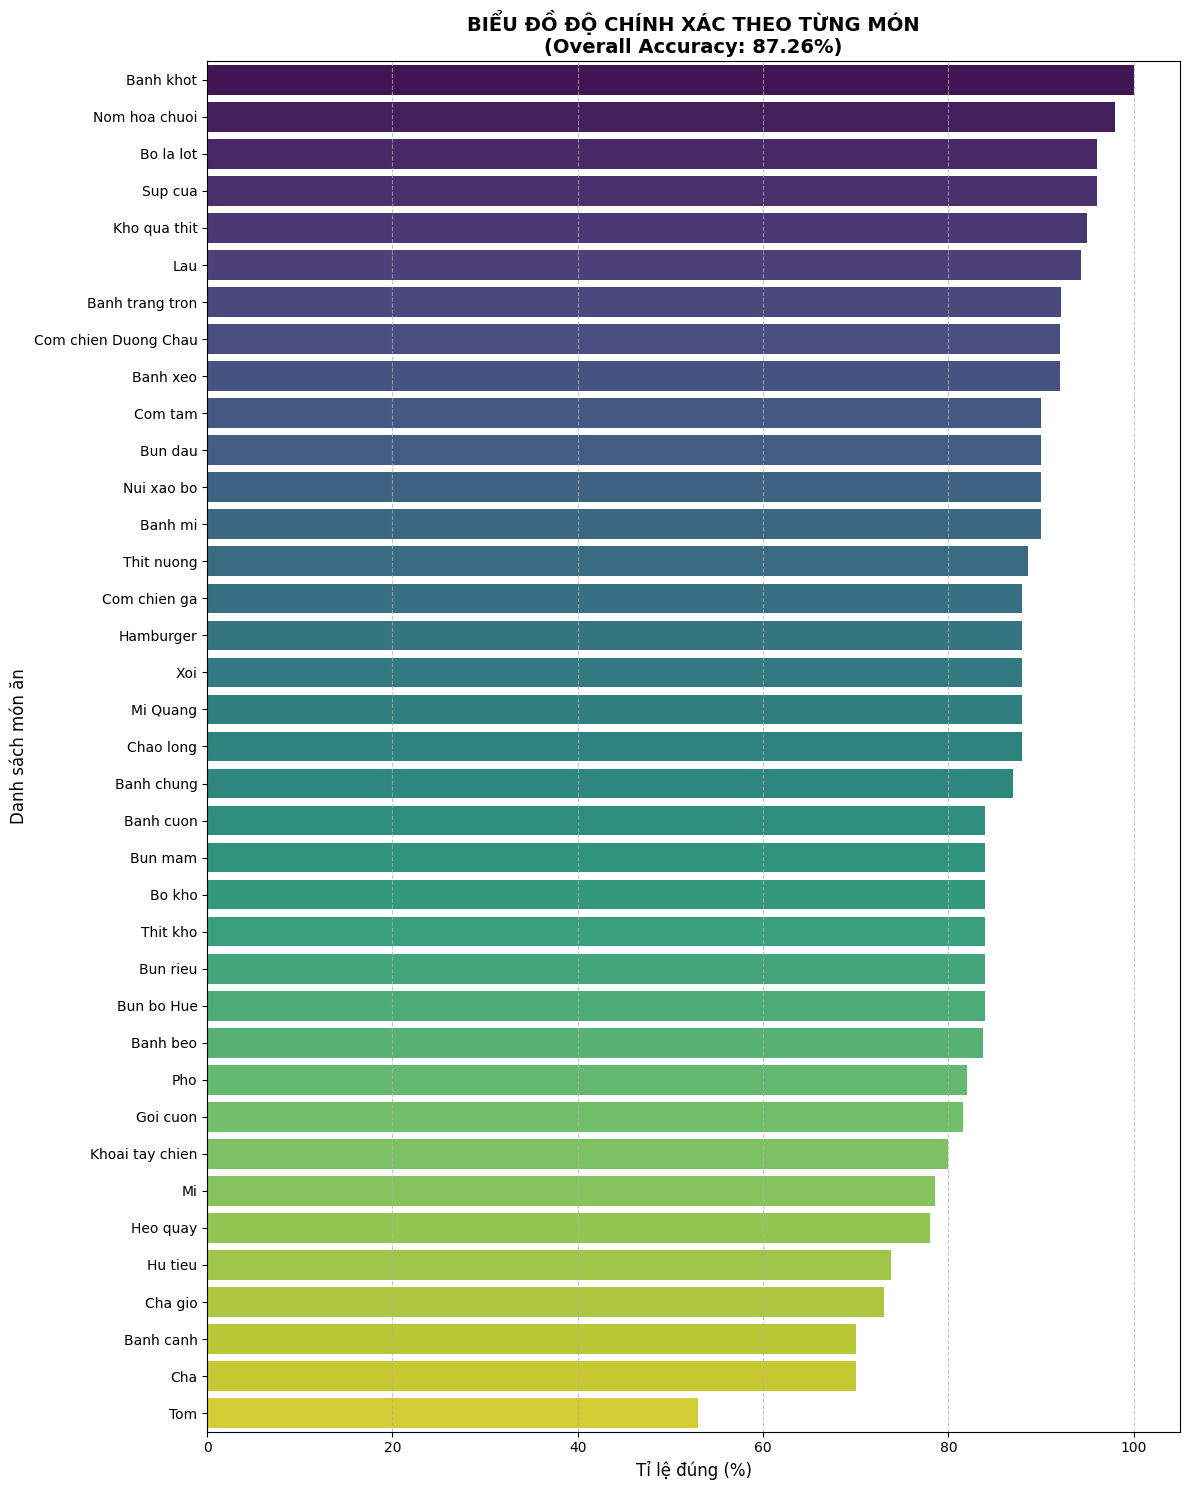


🎉 HOÀN THÀNH ĐÁNH GIÁ MODEL!


In [10]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

# ============================
# CẤU HÌNH ĐƯỜNG DẪN
# ============================
BEST_MODEL = "/content/drive/MyDrive/food_model/food_detection_36class_1100_resume/yolov8s_vietfood_36class_1100/weights/best.pt"

# Đường dẫn đến tập test
IMG_DIR = Path("/content/dataset_filtered/dataset_filtered2/images/test")
LABEL_DIR = Path("/content/dataset_filtered/dataset_filtered2/labels/test")

# Ngưỡng confidence và IOU
CONF_THRES = 0.25
IOU_THRES = 0.45

# ============================
# LOAD MODEL
# ============================
print("📌 Đang load model BEST.PT...\n")
model = YOLO(BEST_MODEL)
class_names = model.names

# ============================
# CHẠY PREDICT TRÊN TẬP TEST
# ============================
records = []

print("🚀 Đang đánh giá model trên tập Test...")

# Kiểm tra thư mục tồn tại
if not IMG_DIR.exists():
    print(f"⚠️ CẢNH BÁO: Thư mục {IMG_DIR} không tồn tại!")
    print("Vui lòng cập nhật đường dẫn IMG_DIR và LABEL_DIR")
else:
    for img_path in tqdm(sorted(IMG_DIR.glob("*.*"))):
        label_path = LABEL_DIR / f"{img_path.stem}.txt"

        # Đọc Ground Truth (Nhãn thật)
        gt_classes = []
        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        gt_classes.append(int(parts[0]))

        # Dự đoán bằng YOLO
        result = model.predict(
            source=str(img_path),
            conf=CONF_THRES,
            iou=IOU_THRES,
            verbose=False
        )[0]

        pred_classes = []
        if result.boxes is not None and len(result.boxes) > 0:
            pred_classes = result.boxes.cls.cpu().numpy().astype(int).tolist()

        records.append({
            "image": img_path.name,
            "gt_classes": gt_classes,
            "pred_classes": pred_classes
        })

    # ============================
    # TÍNH TOÁN THỐNG KÊ CHI TIẾT
    # ============================
    stats_data = []

    for class_id, name in class_names.items():
        # Lọc những ảnh có chứa class này trong thực tế
        subset = [r for r in records if class_id in r['gt_classes']]
        total_samples = len(subset)

        # Tính số lần model nhận diện đúng class đó trong ảnh
        correct_hits = sum(1 for r in subset if class_id in r['pred_classes'])

        accuracy = (correct_hits / total_samples) if total_samples > 0 else 0
        error_rate = 1 - accuracy if total_samples > 0 else 0

        stats_data.append({
            "ID": class_id,
            "Tên món": name,
            "Tổng mẫu": total_samples,
            "Đoán đúng": correct_hits,
            "Đoán sai": total_samples - correct_hits,
            "Tỉ lệ đúng (%)": round(accuracy * 100, 2),
            "Tỉ lệ sai (%)": round(error_rate * 100, 2)
        })

    # Tạo DataFrame
    df_stats = pd.DataFrame(stats_data)

    # ============================
    # HIỂN THỊ KẾT QUẢ
    # ============================
    # Tính Accuracy tổng thể (Image-level)
    total_imgs = len(records)
    correct_imgs = sum(
        1 for r in records
        if r['gt_classes'] and any(c in r['pred_classes'] for c in r['gt_classes'])
    )
    overall_acc = (correct_imgs / total_imgs * 100) if total_imgs > 0 else 0

    print("\n" + "=" * 80)
    print(f"📊 KẾT QUẢ TỔNG THỂ: {overall_acc:.2f}%")
    print(f"Tổng số ảnh test: {total_imgs} | Số ảnh đúng ít nhất 1 object: {correct_imgs}")
    print("=" * 80)

    # Hiển thị bảng chi tiết trên notebook
    print("\n📋 BẢNG CHI TIẾT HIỆU SUẤT CÁC MÓN ĂN:")
    df_sorted = df_stats.sort_values(by="Tỉ lệ đúng (%)", ascending=False).reset_index(drop=True)
    pd.set_option('display.max_rows', None)
    display(df_sorted)

    # ============================
    # VẼ BIỂU ĐỒ TRỰC QUAN
    # ============================
    plt.figure(figsize=(12, 15))
    sns.barplot(x="Tỉ lệ đúng (%)", y="Tên món", data=df_sorted, palette="viridis")
    plt.title(f"BIỂU ĐỒ ĐỘ CHÍNH XÁC THEO TỪNG MÓN\n(Overall Accuracy: {overall_acc:.2f}%)",
              fontsize=14, fontweight='bold')
    plt.xlabel("Tỉ lệ đúng (%)", fontsize=12)
    plt.ylabel("Danh sách món ăn", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n🎉 HOÀN THÀNH ĐÁNH GIÁ MODEL!")

In [ ]:
from ultralytics import YOLO
import torch

# ============================
# CHECK GPU
# ============================
print("🔍 Checking GPU...")
assert torch.cuda.is_available(), "❌ CHƯA BẬT GPU"
print("✅ GPU:", torch.cuda.get_device_name(0))

# ============================
# LOAD MODEL (FINETUNE FROM BEST)
# ============================
model = YOLO(
    "/content/drive/MyDrive/food_model/food_detection_400/food_detection/yolov8s_vietfood_400/weights/best.pt"
)

# ============================
# FINETUNE CONFIG – AGGRESSIVE (DATASET NHỎ)
# ============================
results = model.train(
    # ===== DATA =====
    data="/content/dataset_400/dataset_400/vietfood68_400.yaml",

    # ===== BASIC =====
    epochs=30,             # fine-tune đủ dài
    imgsz=640,
    batch=8,

    # ===== OPTIMIZER =====
    optimizer="AdamW",
    lr0=0.0008,            # 🔥 TĂNG LR để thoát plateau
    lrf=0.005,
    weight_decay=0.001,
    warmup_epochs=4.0,

    # ===== AUGMENTATION (STRONGER) =====
    hsv_h=0.025,
    hsv_s=0.65,
    hsv_v=0.38,

    degrees=10.0,
    translate=0.18,
    scale=0.4,
    shear=1.0,
    perspective=0.0001,

    fliplr=0.5,
    flipud=0.0,

    mosaic=0.7,            # 🔥 QUAN TRỌNG
    mixup=0.1,
    copy_paste=0.05,

    # ===== LOSS =====
    box=9.5,               # 🔥 đẩy bbox
    cls=0.5,
    dfl=2.0,

    # ===== SYSTEM =====
    device=0,
    workers=2,
    cache=False,
    amp=True,

    # ===== EARLY STOP =====
    patience=25,

    # ===== OUTPUT (FOLDER MỚI) =====
    project="/content/drive/MyDrive/food_model/food_detection_400/food_detection",
    name="yolov8s_vietfood_400_finetune_v1",
    exist_ok=False,        # ❗ không ghi đè
    plots=True,
    verbose=True
)

print("✅ FINETUNE DONE")
print("📁 Saved at:")
print("/content/drive/MyDrive/food_model/food_detection_400/food_detection/yolov8s_vietfood_400_finetune_v1")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Checking GPU...
✅ GPU: Tesla T4
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=9.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.05, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_400/dataset_400/vietfood68_400.yaml, degrees=10.0, deterministic=True, device=0, dfl=2.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0

In [ ]:
# Copy toàn bộ folder food_detection_600 sang Drive
cp -r /content/food_detection_600 /content/drive/MyDrive/

In [ ]:
import os
folder_path = "/content/dataset_300"

# Kiểm tra trước khi xóa
if os.path.exists(folder_path):
    !rm -r "{folder_path}"
    print("✅ Folder đã được xóa.")
else:
    print("❌ Folder không tồn tại.")


✅ Folder đã được xóa.
